# Baseline model - simple MLP


Imports:

In [1]:
import copy
import pandas as pd
import numpy as np
import pathlib
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

read data:

In [2]:
df_hard = pd.read_excel('all_data_long.xlsx')

In [3]:
df_hard['Fictive ID'].nunique()

29128

In [4]:
df = copy.deepcopy(df_hard)
df.columns = df.columns.str.replace("'", "")
features_to_start = ['year', 'מין', 'סוג פיקוח', ' פסיכומטרי רב תחומי', 'פסיכומטרי כמותי', 'פסיכומטרי מילולי',
               'שפת פסיכומטרי', 'בגרות', 'ציון מכינה', 'ציון אנגלית', 'ניקוד רל"ק', 'שנת לידה', 'פקולטה', 'חוג', 'מסלול', 'משקולל קיים', 'נשר חיצונית']
df = df[features_to_start]

feature_names_to_replace = {"מין": "gender", 'סוג פיקוח': 'supervision_type',
                        ' פסיכומטרי רב תחומי': 'psico_rav', 'פסיכומטרי כמותי':'psico_camul',
                        'פסיכומטרי מילולי':'psico_verb', 'שפת פסיכומטרי': 'psico_leng',
                        'בגרות':'bag', 'ציון מכינה':'preparatory_score', 'ציון אנגלית':'eng_score', 'ניקוד רל"ק':'ralak_score',
                        'שנת לידה':'birth_year', 'פקולטה':'faculty',
                        'חוג':'hug', 'מסלול':'study_track', 'משקולל קיים':'weighted_score', 'נשר חיצונית':'dropouts'}

df = df.rename(columns=feature_names_to_replace)

split to train and test:

In [5]:
X = df.drop('dropouts', axis=1)
Y = df['dropouts'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)

# Reset indices for compatibility
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

build base model:

In [6]:
class DropuotsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features.iloc[idx].values, dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }


In [7]:
class BaseModelNN(nn.Module):
    def __init__(self, input_dim):
        super(BaseModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 12)
        self.fc2 = nn.Linear(12, 6)
        self.output = nn.Linear(6, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x

training loop:

In [8]:
numeric_features = X_train.select_dtypes(include=['number']).columns

In [9]:
# Create DataLoader
batch_size = 32
train_dataset = DropuotsDataset(X_train[numeric_features], y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test[numeric_features], y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

initialize model and optimizer:

In [10]:
model = BaseModelNN(input_dim=X_train[numeric_features].shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    model.to(device)  # Move model to the specified device (CPU or GPU)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for batch in train_loader:
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)  # Ensure labels are shaped as (batch_size, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")

In [139]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 96.4461
Epoch [2/10], Loss: 96.4461
Epoch [3/10], Loss: 96.4448
Epoch [4/10], Loss: 96.4461
Epoch [5/10], Loss: 96.4435
Epoch [6/10], Loss: 96.4435
Epoch [7/10], Loss: 96.4461
Epoch [8/10], Loss: 96.4448
Epoch [9/10], Loss: 96.4461
Epoch [10/10], Loss: 96.4448
Training complete.


evaluation:

In [12]:
def evaluate_model(model, data_loader, criterion, device, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions and probabilities
            probabilities = outputs.squeeze().cpu().numpy()  # Convert to numpy array
            predictions = (probabilities >= threshold).astype(int)  # Threshold for binary classification
            labels = labels.cpu().numpy()  # Convert labels to numpy

            # Store results
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            all_probs.extend(probabilities)

    # Compute average loss
    avg_loss = total_loss / len(data_loader)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"Evaluation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return {'loss': avg_loss,
            'accuracy_score': accuracy,
            'precision_score': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'lables': all_labels,
            'predictions': all_predictions,
            'probabilities': all_probs}


In [ ]:
test_eval_results = evaluate_model(model, test_loader, criterion, device)

Evaluation Results:
Loss: 96.2411
Accuracy: 0.0377
Precision: 0.0377
Recall: 1.0000
F1 Score: 0.0726
ROC AUC: 0.5000


In [142]:
set(test_eval_results['predictions'])

{np.int64(1)}

this model practically predicts all students will drop. this is obviousley not good.

# Enhancements: 
change the model architecture and preprocess data to achive better results

## add layers and neurons:

In [13]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x


model = MLPModelNN(input_dim=X_train[numeric_features].shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.AdamW(model.parameters(), lr=0.01)

In [242]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.1640
Epoch [2/10], Loss: 0.1556
Epoch [3/10], Loss: 0.1540
Epoch [4/10], Loss: 0.1537
Epoch [5/10], Loss: 0.1537
Epoch [6/10], Loss: 0.1537
Epoch [7/10], Loss: 0.1538
Epoch [8/10], Loss: 0.1539
Epoch [9/10], Loss: 0.1538
Epoch [10/10], Loss: 0.1538
Training complete.


In [ ]:
test_eval_results = evaluate_model(model, test_loader, criterion, device)

Evaluation Results:
Loss: 0.1602
Accuracy: 0.9623
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000


c:\Users\nadavkat\OneDrive - Intel Corporation\Documents\Learning\University\University-Dropouts-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


It seems like adding layers dosent solve the problem, and the model is still not preforming well.

## preprocess data:
The data preprocess is based on knowledge about this specific usecase and data, as revised by an SME

In [14]:
def preprocess_data(data):
    df = data.copy()
    
    # encode categorical binary variables:
    df['gender'] = np.where(df['gender'] == 'ז', 0, 1)
    df['study_track'] = np.where(df['study_track'] == 'חד חוגי', 0, 1)
    
    # remove samples with 0 bagrut score:
    df = df[df['bag'] != 0]# remove 1252 samples
    
    df['supervision_type'] = np.where(df['supervision_type'].isna(), 'missing', df['supervision_type'])
    
    # df['ralak'] = np.where(df['ralak_score'] >= 30, 1, 0)
    # df.pop('ralak_score')
    
    # learned in preparatory at huji:
    df['preparatory'] = np.where(df['preparatory_score'] > 0, 1, 0)
    df.pop('preparatory_score')
    
    # create age feature:
    df['age'] = df['year'] - df['birth_year']
    df.pop('birth_year')
    # df.pop('חוג')
    # df.pop('פקולטה')
    
    # create dummy variables for hug:
    df = pd.get_dummies(df, columns=['hug'], dtype=float)
    
    return df

In [15]:
df_prep = preprocess_data(df)

In [16]:
X = df_prep.drop('dropouts', axis=1)
Y = df_prep['dropouts'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)

# Reset indices for compatibility
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

In [17]:
# Create DataLoader
numeric_features = X_train.select_dtypes(include=['number']).columns

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


batch_size = 32
train_dataset = DropuotsDataset(X_train[numeric_features], y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test[numeric_features], y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [29]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x


model = MLPModelNN(input_dim=X_train[numeric_features].shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.AdamW(model.parameters(), lr=0.01)

In [ ]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.1618
Epoch [2/10], Loss: 0.1513
Epoch [3/10], Loss: 0.1510
Epoch [4/10], Loss: 0.1498
Epoch [5/10], Loss: 0.1493
Epoch [6/10], Loss: 0.1488
Epoch [7/10], Loss: 0.1488
Epoch [8/10], Loss: 0.1532
Epoch [9/10], Loss: 0.1489
Epoch [10/10], Loss: 0.1481
Training complete.


In [34]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=0.05)

Evaluation Results:
Loss: 0.1420
Accuracy: 0.6212
Precision: 0.0523
Recall: 0.6154
F1 Score: 0.0964
ROC AUC: 0.6424


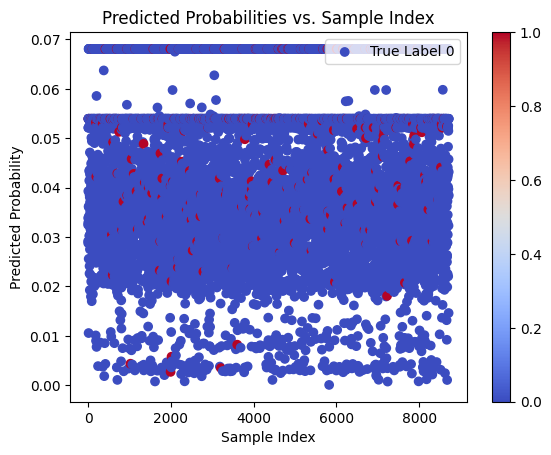

In [35]:
# plot the probabilities of the model and color each point by the true label, and add legend to the plot:
plt.scatter(range(len(test_eval_results['probabilities'])), test_eval_results['probabilities'], c=test_eval_results['lables'], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities vs. Sample Index')
plt.legend(['True Label 0', 'True Label 1'], loc='upper right')
plt.show()


maybe add class weight and use BCEWithLogitLoss, need to add pos_weight argument. 